## Goal

To produce datapoints in 7d space by building 7-spheres in all orthants (2 concentric spheres of radii, say, 1 and 2 in all orthants,
centered at say, a distance of 4 from all axes) in a non-uniform fashion, i.e., some orthants would have fewer points and some more points
(say, 25% of the orthants have fewer points, perhaps ~25 points in most orthants and ~4 points in the rarer orthants).

We wish to determine the performance of a neural network for different orthants - does it perform equally well or similar in all orthants,
determining that there is symmetry present in the data? Or does it fail to do so, doing well only in the orthants with more data? We use a
test set of say, 128 points per orthant to quantify each orthant's performance.

## Data

### Defining constants

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
LOW_COUNT = 4   # Average no. of points in a "rare" orthant
HIGH_COUNT = 25 # Average no. of points in a "typical" orthant
LOW_SPREAD = 2  # Allowed unidirectional deviation for no. of points in a "rare" orthant (i.e., 2 to 6 points)
HIGH_SPREAD = 8 # Allowed unidirectional deviation for no. of points in a "typical" orthant (i.e., 17 to 33 points)
VAL_COUNT = 4   # Validation data points per orthant
TEST_COUNT = 64 # Test data points per orthant, for final pattern
LOW_FRAC = 0.25 # Fraction of "rare" orthants
ZERO_FRAC = 0.25    # Fraction of empty orthants from rare orthants

In [3]:
CENTRE = 4 * torch.ones(7)
# The centre of the 7-spheres, without orthant-specificity, which can be included using ORTHANTS
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [4]:
LOW_RADIUS = 1. # Radius of the inner sphere (say, label 0) in each orthant
HIGH_RADIUS = 2.    # Radius of the outer sphere (say, label 1) in each orthant

### Data generation

Now, we describe a 7-sphere using the standard notation. <br>
Say, it is centered at $C = (C_1, C_2, ..., C_7)$ and has radius $r$. Each point can be described with the help of 6 angles, <br>
$\phi_1$, $\phi_2$, $\phi_3$, $\phi_4$, $\phi_5$, and $\phi_6$, where $\phi_6 \in [0, 2\pi)$ and $\phi_1, ..., \phi_5 \in [0, \pi]$ <br>
Any point $x = (x_1, x_2, ..., x_7)$ on the sphere can be described as follows: <br>
$x_1 = C_1 + r\cos(\phi_1)$ <br>
$x_2 = C_2 + r\sin(\phi_1)\cos(\phi_2)$ <br>
$x_3 = C_3 + r\sin(\phi_1)\sin(\phi_2)\cos(\phi_3)$ <br>
$x_4 = C_4 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\cos(\phi_4)$ <br>
$x_5 = C_5 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\cos(\phi_5)$ <br>
$x_6 = C_6 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\cos(\phi_6)$ <br>
$x_7 = C_7 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\sin(\phi_6)$
<br>

Hence, each datapoint will be sampled by randomly generating the 6 angles from appropriate uniform distributions and 
performing the mentioned transformation

#### Train data

In [5]:
from scripts.data.orthants import generate_train_data, generate_test_data, generate_flips

In [6]:
flips = generate_flips(0.2)

In [7]:
X_training, Y_training, orthant_counts = generate_train_data()
X_training.shape, Y_training.shape

(torch.Size([4857, 7]), torch.Size([4857, 1]))

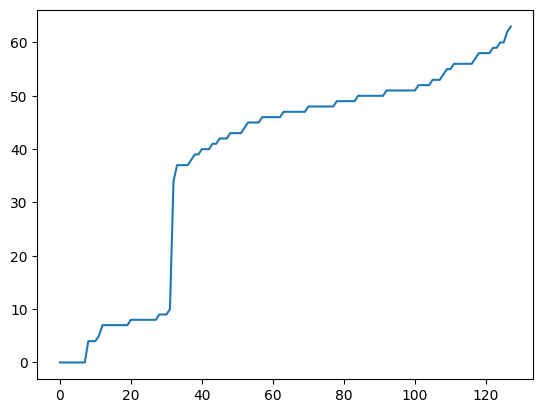

In [8]:
plt.plot(range(128), torch.sort(orthant_counts).values)

In [9]:
ZERO_ORTHANT_INDICES, LOW_ORTHANT_INDICES, HIGH_ORTHANT_INDICES = [], [], []
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDICES.append(i)
    elif orthant_counts[i] <= 2*(LOW_COUNT+LOW_SPREAD): 
        LOW_ORTHANT_INDICES.append(i)
    else:
        HIGH_ORTHANT_INDICES.append(i)
len(ZERO_ORTHANT_INDICES), len(LOW_ORTHANT_INDICES), len(HIGH_ORTHANT_INDICES)

(8, 24, 96)

In [10]:
ZERO_ORTHANT_INDICES_FLIP, LOW_ORTHANT_INDICES_FLIP, HIGH_ORTHANT_INDICES_FLIP = [], [], []
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDICES_FLIP.append(i)
    elif orthant_counts[i] <= 2*(LOW_COUNT+LOW_SPREAD):
        LOW_ORTHANT_INDICES_FLIP.append(i)
    else:
        HIGH_ORTHANT_INDICES_FLIP.append(i)
len(ZERO_ORTHANT_INDICES_FLIP), len(LOW_ORTHANT_INDICES_FLIP), len(HIGH_ORTHANT_INDICES_FLIP)

(8, 24, 96)

In [11]:
X_training_flip, Y_training_flip, orthant_counts_flip = generate_train_data(flips=flips)
X_training_flip.shape, Y_training_flip.shape, flips.sum()

(torch.Size([4941, 7]),
 torch.Size([4941, 1]),
 tensor(26., dtype=torch.float64))

#### Train-Validation split

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([3885, 7]),
 torch.Size([972, 7]),
 torch.Size([3885, 1]),
 torch.Size([972, 1]))

In [13]:
X_train_flip, X_val_flip, Y_train_flip, Y_val_flip = train_test_split(X_training_flip, Y_training_flip, test_size=0.2)
X_train_flip.shape, X_val_flip.shape, Y_train_flip.shape, Y_val_flip.shape

(torch.Size([3952, 7]),
 torch.Size([989, 7]),
 torch.Size([3952, 1]),
 torch.Size([989, 1]))

#### Test data

In [14]:
X_test, Y_test = generate_test_data()
X_test.shape, Y_test.shape

(torch.Size([128, 128, 7]), torch.Size([128, 128, 1]))

In [15]:
X_test_flip, Y_test_flip = generate_test_data(flips=flips)
X_test_flip.shape, Y_test_flip.shape, flips.sum()

(torch.Size([128, 128, 7]),
 torch.Size([128, 128, 1]),
 tensor(26., dtype=torch.float64))

#### Data for hyperparameter tuning

In [16]:
from sklearn.utils import resample

X_train_cv, Y_train_cv = resample(X_train, Y_train, replace=False, n_samples=len(X_train)//5)
X_val_cv, Y_val_cv = resample(X_val, Y_val, replace=False, n_samples=len(X_val)//5)
X_train_cv.shape, X_val_cv.shape, Y_train_cv.shape, Y_val_cv.shape

(torch.Size([777, 7]),
 torch.Size([194, 7]),
 torch.Size([777, 1]),
 torch.Size([194, 1]))

In [17]:
X_train_flip_cv, Y_train_flip_cv = resample(X_train_flip, Y_train_flip, replace=False, n_samples=len(X_train_flip)//5)
X_val_flip_cv, Y_val_flip_cv = resample(X_val_flip, Y_val_flip, replace=False, n_samples=len(X_val_flip)//5)
X_train_flip_cv.shape, X_val_flip_cv.shape, Y_train_flip_cv.shape, Y_val_flip_cv.shape

(torch.Size([790, 7]),
 torch.Size([197, 7]),
 torch.Size([790, 1]),
 torch.Size([197, 1]))

## Neural network

In [18]:
device = 'cpu'

In [19]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(
        self,
        hidden_layers: int = 2,
        hidden_units: int = 32
    ) -> None:
        super().__init__()
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.input = nn.Sequential(
            nn.Linear(in_features=7, out_features=hidden_units),
            nn.ReLU()
        )
        self.hidden = nn.Sequential()
        for i in range(hidden_layers):
            self.hidden.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
            self.hidden.append(nn.ReLU())
        self.output = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.output(self.hidden(self.input(x)))


In [20]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32, shuffle=True)
train_cv_dataloader, val_cv_dataloader = make_dataloader(X_train_cv, Y_train_cv, batch_size=32, shuffle=True), make_dataloader(X_val_cv, Y_val_cv, batch_size=32, shuffle=True)
train_flip_dataloader, val_flip_dataloader = make_dataloader(X_train_flip, Y_train_flip, batch_size=32, shuffle=True), make_dataloader(X_val_flip, Y_val_flip, batch_size=32, shuffle=True)
train_flip_cv_dataloader, val_flip_cv_dataloader = make_dataloader(X_train_flip_cv, Y_train_flip_cv, batch_size=32, shuffle=True), make_dataloader(X_val_flip_cv, Y_val_flip_cv, batch_size=32, shuffle=True)

In [21]:
depths = [1, 2, 3, 4, 5]
widths = [16, 32, 64]
lambdas = [0, 1e-7, 1e-6, 1e-5]
etas = [1e-2, 1e-3, 1e-4]
betass = [(0.9, 0.999), (0.9, 0.99), (0.8, 0.9)]

### Without class flipping

In [22]:
best_depth = None
best_width = None
best_lambda = None
best_eta = None
best_betas = None
best_score = -1

In [23]:
from scripts.metrics import BinaryAccuracy
from scripts.train import train_model
from scripts.test import predict

count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 50
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_cv_dataloader,
                        val_dataloader=val_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_lambda = lambda_i
                        best_eta = eta
                        best_betas = betas

print(f'Results:\nDepth: {best_depth}\nWidth: {best_width}\nLambda: {best_lambda}\nEta: {best_eta}\nBetas: {best_betas}\nAccuracy after {EPOCHS} epochs: {best_score}')

Model 1 of 540 trained. Validation accuracy: 0.5625
Model 2 of 540 trained. Validation accuracy: 0.5669642686843872
Model 3 of 540 trained. Validation accuracy: 0.7053571343421936
Model 4 of 540 trained. Validation accuracy: 0.5803571343421936
Model 5 of 540 trained. Validation accuracy: 0.4330357015132904
Model 6 of 540 trained. Validation accuracy: 0.5446428656578064
Model 7 of 540 trained. Validation accuracy: 0.5133928656578064
Model 8 of 540 trained. Validation accuracy: 0.5133928656578064
Model 9 of 540 trained. Validation accuracy: 0.5357142686843872
Model 10 of 540 trained. Validation accuracy: 0.5089285969734192
Model 11 of 540 trained. Validation accuracy: 0.6205357313156128
Model 12 of 540 trained. Validation accuracy: 0.5803571343421936
Model 13 of 540 trained. Validation accuracy: 0.53125
Model 14 of 540 trained. Validation accuracy: 0.4776785671710968
Model 15 of 540 trained. Validation accuracy: 0.5044642686843872
Model 16 of 540 trained. Validation accuracy: 0.495535701

In [24]:
best_model_nn = SimpleNN(hidden_layers=best_depth, hidden_units=best_width).to(device)

In [25]:
from scripts.metrics import BinaryAccuracy

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, betas=best_betas, weight_decay=best_lambda)
metric = BinaryAccuracy()

In [26]:
from scripts.utils import EarlyStopping

early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [27]:
from scripts.train import train_model

history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device,
    return_models=True
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.693362, Train score: 0.510187, Val loss: 0.693073, Val score: 0.510081
Epoch: 2 => Train loss: 0.691918, Train score: 0.517517, Val loss: 0.693293, Val score: 0.502688
Epoch: 3 => Train loss: 0.690613, Train score: 0.533358, Val loss: 0.693883, Val score: 0.513777
Epoch: 4 => Train loss: 0.689016, Train score: 0.539388, Val loss: 0.695088, Val score: 0.522850
Epoch: 5 => Train loss: 0.687006, Train score: 0.543368, Val loss: 0.694108, Val score: 0.528226
Epoch: 6 => Train loss: 0.685513, Train score: 0.552963, Val loss: 0.696370, Val score: 0.513777
Epoch: 7 => Train loss: 0.682989, Train score: 0.562815, Val loss: 0.694916, Val score: 0.517473
Epoch: 8 => Train loss: 0.680628, Train score: 0.565791, Val loss: 0.697152, Val score: 0.515793
Epoch: 9 => Train loss: 0.678065, Train score: 0.573140, Val loss: 0.695604, Val score: 0.535954
Epoch: 10 => Train loss: 0.674508, Train score: 0.582519, Val loss: 0.69

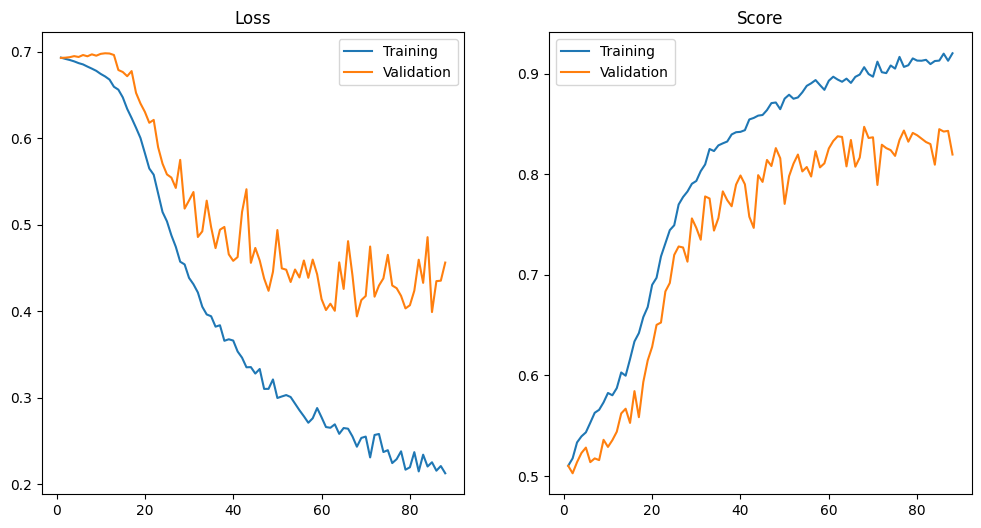

In [28]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [29]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(best_model_nn, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

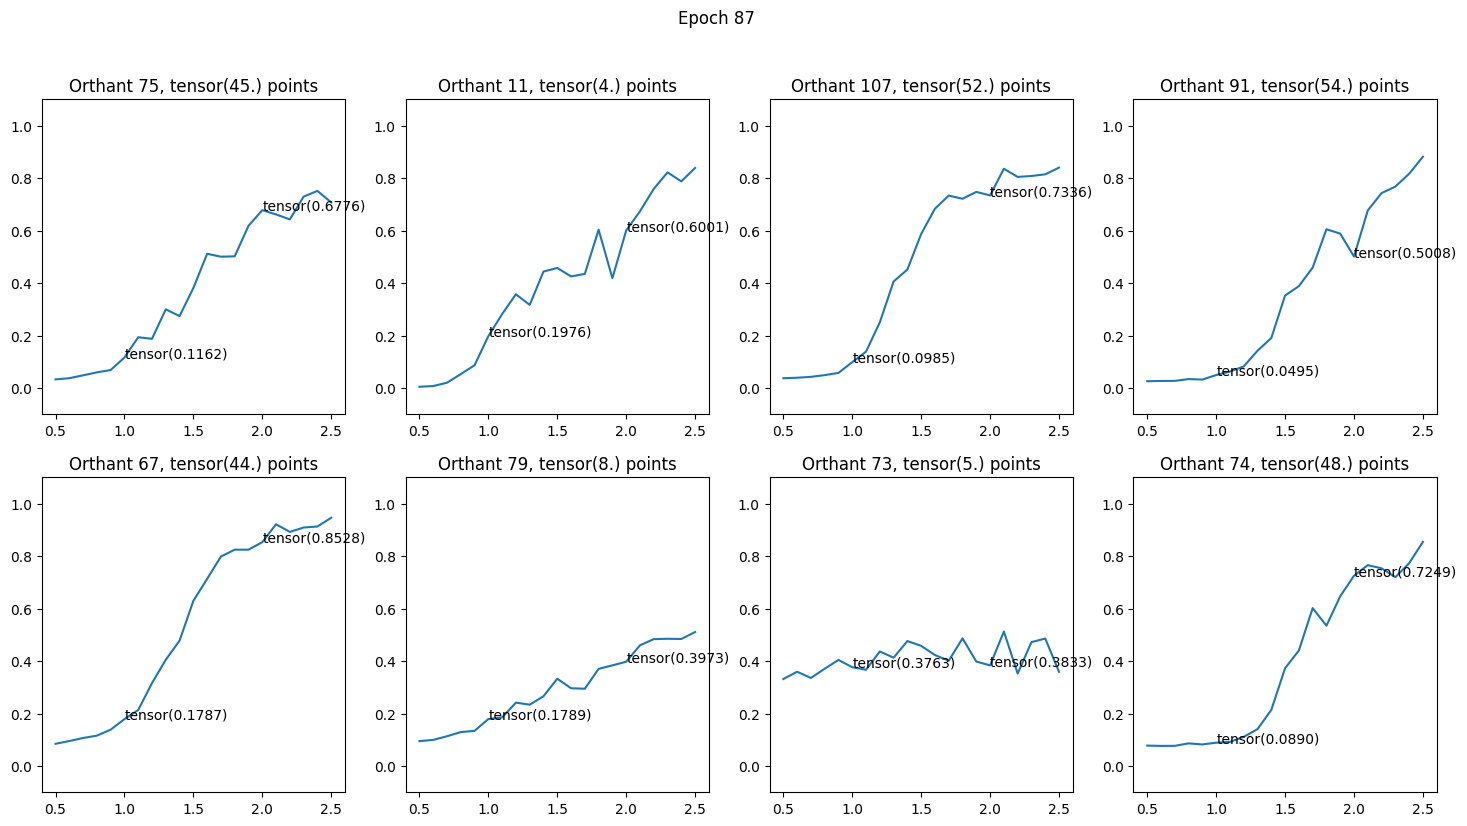

In [30]:
from scripts.utils import plot_radial_visualization

plot_radial_visualization(
    models=history['models'],
    mp4_save_file_name='radial',
    orthant_counts=orthant_counts,
    fps=4,
    device=device
) # track progress if possible, add a verbose parameter

In [31]:
# from scripts.utils import plot_2d_visualization

# plot_2d_visualization(
#     X_train=X_train,
#     Y_train=Y_train,
#     models=history['models'],
#     gif_save_file_name='2DProjection_1'
# )

### With class flipping in random orthants

In [32]:
best_depth_flip = None
best_width_flip = None
best_lambda_flip = None
best_eta_flip = None
best_betas_flip = None
best_score_flip = -1

In [33]:
count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 32
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_flip_cv_dataloader,
                        val_dataloader=val_flip_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score_flip:
                        best_score_flip = score
                        best_depth_flip = depth
                        best_width_flip = width
                        best_lambda_flip = lambda_i
                        best_eta_flip = eta
                        best_betas_flip = betas

print(f'Results:\nDepth: {best_depth_flip}\nWidth: {best_width_flip}\nLambda: {best_lambda_flip}\nEta: {best_eta_flip}\nBetas: {best_betas_flip}\nAccuracy after {EPOCHS} epochs: {best_score_flip}')

Model 1 of 540 trained. Validation accuracy: 0.518750011920929
Model 2 of 540 trained. Validation accuracy: 0.5321428179740906
Model 3 of 540 trained. Validation accuracy: 0.5705357193946838
Model 4 of 540 trained. Validation accuracy: 0.5080357193946838
Model 5 of 540 trained. Validation accuracy: 0.49464288353919983
Model 6 of 540 trained. Validation accuracy: 0.5160714387893677
Model 7 of 540 trained. Validation accuracy: 0.5544642806053162
Model 8 of 540 trained. Validation accuracy: 0.5098214149475098
Model 9 of 540 trained. Validation accuracy: 0.46875
Model 10 of 540 trained. Validation accuracy: 0.4616071581840515
Model 11 of 540 trained. Validation accuracy: 0.516964316368103
Model 12 of 540 trained. Validation accuracy: 0.5696428418159485
Model 13 of 540 trained. Validation accuracy: 0.5562499761581421
Model 14 of 540 trained. Validation accuracy: 0.4705357253551483
Model 15 of 540 trained. Validation accuracy: 0.545535683631897
Model 16 of 540 trained. Validation accuracy: 0

In [34]:
best_model_flip_nn = SimpleNN(hidden_layers=best_depth_flip, hidden_units=best_width_flip).to(device)

In [35]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_flip_nn.parameters(), lr=best_eta_flip, betas=best_betas_flip, weight_decay=best_lambda_flip)
metric = BinaryAccuracy()

In [36]:
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [37]:
history = train_model(
    model=best_model_flip_nn,
    train_dataloader=train_flip_dataloader,
    val_dataloader=val_flip_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.695669, Train score: 0.505544, Val loss: 0.695184, Val score: 0.483315
Epoch: 2 => Train loss: 0.693279, Train score: 0.510081, Val loss: 0.695745, Val score: 0.500556
Epoch: 3 => Train loss: 0.693406, Train score: 0.512349, Val loss: 0.693546, Val score: 0.495620
Epoch: 4 => Train loss: 0.693330, Train score: 0.508065, Val loss: 0.693873, Val score: 0.490858
Epoch: 5 => Train loss: 0.693679, Train score: 0.494204, Val loss: 0.693455, Val score: 0.477371
Epoch: 6 => Train loss: 0.692826, Train score: 0.508569, Val loss: 0.693786, Val score: 0.479387
Epoch: 7 => Train loss: 0.692287, Train score: 0.513357, Val loss: 0.695094, Val score: 0.498644
Epoch: 8 => Train loss: 0.692713, Train score: 0.515625, Val loss: 0.694883, Val score: 0.484427
Epoch: 9 => Train loss: 0.692694, Train score: 0.505040, Val loss: 0.693554, Val score: 0.508204
Epoch: 10 => Train loss: 0.693137, Train score: 0.513357, Val loss: 0.69

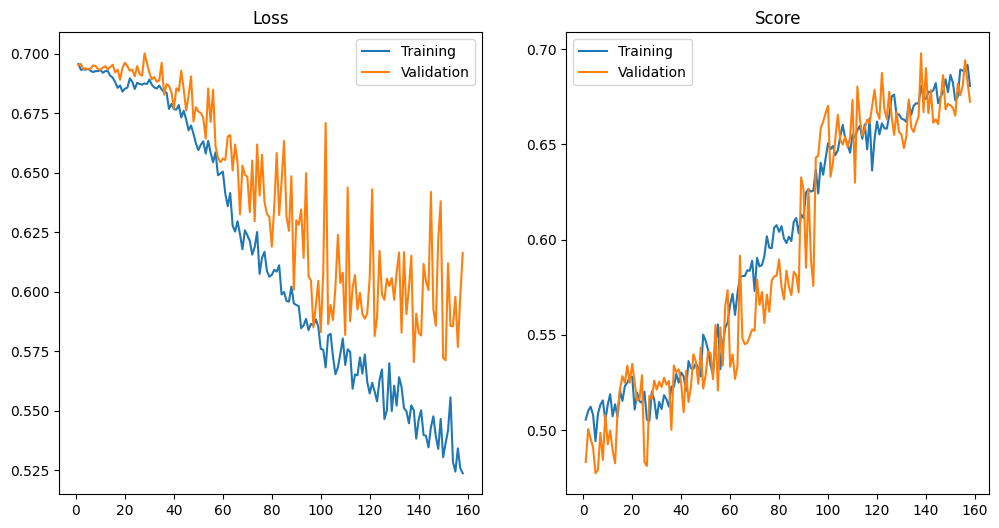

In [38]:
plot_train_history(history)

In [39]:
scores_flip_nn = torch.tensor([
    metric(
        predict(best_model_flip_nn, X_test_flip[i], device),
        Y_test_flip[i]
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, NN')

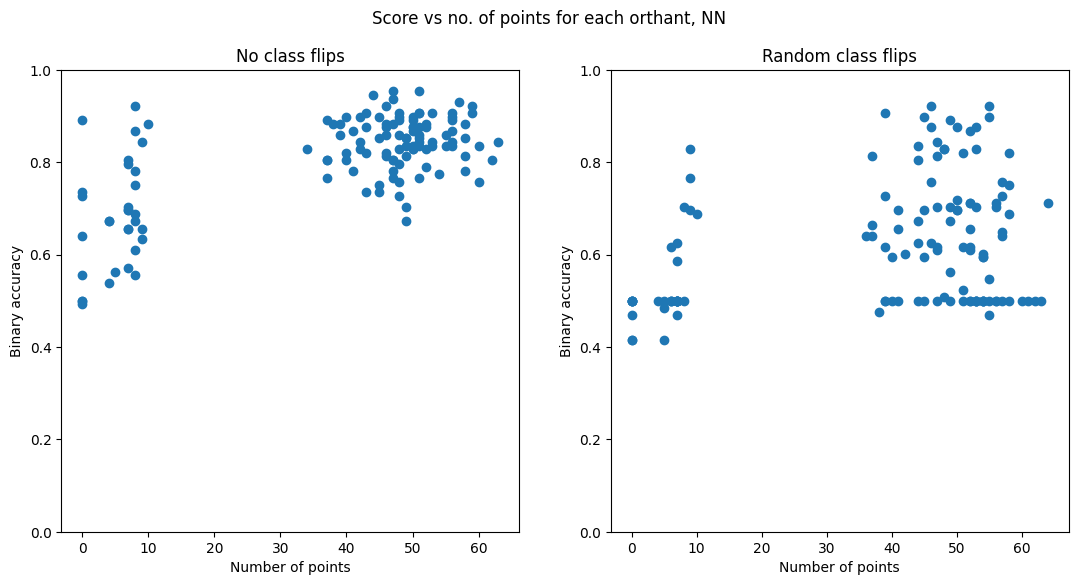

In [40]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('No class flips')

plt.subplot(122)
plt.scatter(orthant_counts_flip, scores_flip_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('Random class flips')

plt.suptitle('Score vs no. of points for each orthant, NN')

In [41]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_nn).statistic, pearsonr(orthant_counts_flip, scores_flip_nn).statistic

(0.6741883386720171, 0.32657526329858844)

In [42]:
scores_nn.mean(), scores_flip_nn.mean()

(tensor(0.8054), tensor(0.6202))

In [43]:
print('Performance in empty orthants: ', scores_nn[ZERO_ORTHANT_INDICES].mean(), scores_flip_nn[ZERO_ORTHANT_INDICES_FLIP].mean())
print('Performance in rare orthants: ', scores_nn[LOW_ORTHANT_INDICES].mean(), scores_flip_nn[LOW_ORTHANT_INDICES_FLIP].mean())
print('Performance in typical orthants: ', scores_nn[HIGH_ORTHANT_INDICES].mean(), scores_flip_nn[HIGH_ORTHANT_INDICES_FLIP].mean())

Performance in empty orthants:  tensor(0.6299) tensor(0.6182)
Performance in rare orthants:  tensor(0.7035) tensor(0.6234)
Performance in typical orthants:  tensor(0.8455) tensor(0.6196)


Okay, maybe a neural network can find symmetry? Can an SVM do this too? Is the test data too similar to training?

## SVM

In [44]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [45]:
ntk = NTK(best_model_nn).get_ntk

In [46]:
model_base_ntk = SVC(kernel=ntk)
params_ntk = {
    'C': np.logspace(-5, 5, 11)
}

gammas = np.logspace(-5, 5, 11).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVC(kernel='rbf')
params_rbf = {
    'C': np.logspace(-5, 5, 11),
    'gamma': gammas
}

scorer = make_scorer(accuracy_score)

### Without class flipping

In [47]:
model_cv_ntk = GridSearchCV(
    estimator=model_base_ntk,
    param_grid=params_ntk,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_ntk.fit(X_train_cv, Y_train_cv.squeeze())
best_params_ntk = model_cv_ntk.best_params_
best_params_ntk

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ...........................C=1e-05;, score=0.532 total time=   1.4s
[CV 2/5] END ...........................C=1e-05;, score=0.532 total time=   1.4s
[CV 4/5] END ...........................C=1e-05;, score=0.535 total time=   1.4s
[CV 3/5] END ...........................C=1e-05;, score=0.535 total time=   1.4s
[CV 5/5] END ...........................C=1e-05;, score=0.529 total time=   1.4s
[CV 3/5] END ..........................C=0.0001;, score=0.535 total time=   1.4s
[CV 4/5] END ..........................C=0.0001;, score=0.542 total time=   1.4s
[CV 1/5] END ..........................C=0.0001;, score=0.538 total time=   1.4s
[CV 2/5] END ..........................C=0.0001;, score=0.532 total time=   1.5s
[CV 5/5] END ..........................C=0.0001;, score=0.529 total time=   1.5s
[CV 1/5] END ...........................C=0.001;, score=0.545 total time=   1.4s
[CV 2/5] END ...........................C=0.001;

{'C': 10.0}

In [48]:
model_cv_rbf = GridSearchCV(
    estimator=model_base_rbf,
    param_grid=params_rbf,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_rbf.fit(X_train_cv, Y_train_cv.squeeze())
best_params_rbf = model_cv_rbf.best_params_
best_params_rbf

Fitting 5 folds for each of 143 candidates, totalling 715 fits
[CV 1/5] END ..............C=1e-05, gamma=1e-05;, score=0.532 total time=   0.0s
[CV 3/5] END ..............C=1e-05, gamma=1e-05;, score=0.535 total time=   0.0s
[CV 4/5] END ..............C=1e-05, gamma=1e-05;, score=0.535 total time=   0.0s
[CV 2/5] END ..............C=1e-05, gamma=1e-05;, score=0.532 total time=   0.0s
[CV 5/5] END ..............C=1e-05, gamma=1e-05;, score=0.529 total time=   0.0s
[CV 1/5] END .............C=1e-05, gamma=0.0001;, score=0.532 total time=   0.0s
[CV 2/5] END .............C=1e-05, gamma=0.0001;, score=0.532 total time=   0.0s
[CV 3/5] END .............C=1e-05, gamma=0.0001;, score=0.535 total time=   0.0s
[CV 4/5] END .............C=1e-05, gamma=0.0001;, score=0.535 total time=   0.0s
[CV 1/5] END ..............C=1e-05, gamma=0.001;, score=0.532 total time=   0.0s
[CV 5/5] END .............C=1e-05, gamma=0.0001;, score=0.529 total time=   0.0s
[CV 3/5] END ..............C=1e-05, gamma=0.00

{'C': 1.0, 'gamma': 1.0}

In [49]:
best_score_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
best_score_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])

if best_score_rbf >= best_score_ntk:
    best_model_km = SVC(C=best_params_rbf['C'], kernel='rbf', gamma=best_params_rbf['gamma'])
else:
    best_model_km = SVC(C=best_params_ntk['C'], kernel=ntk)

In [50]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(C=10.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f634c058580>>)

In [51]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(0.9881595881595882, 0.8353909465020576)

In [52]:
scores_km = np.array([
    accuracy_score(
        best_model_km.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

### With class flipping in random orthants

In [53]:
model_cv_ntk = GridSearchCV(
    estimator=model_base_ntk,
    param_grid=params_ntk,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_ntk.fit(X_train_flip_cv, Y_train_flip_cv.squeeze())
best_params_flip_ntk = model_cv_ntk.best_params_
best_params_flip_ntk

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 2/5] END ...........................C=1e-05;, score=0.506 total time=   1.3s
[CV 1/5] END ...........................C=1e-05;, score=0.506 total time=   1.3s
[CV 3/5] END ...........................C=1e-05;, score=0.506 total time=   1.4s
[CV 4/5] END ...........................C=1e-05;, score=0.506 total time=   1.4s
[CV 5/5] END ...........................C=1e-05;, score=0.500 total time=   1.4s
[CV 1/5] END ..........................C=0.0001;, score=0.513 total time=   1.4s
[CV 2/5] END ..........................C=0.0001;, score=0.519 total time=   1.4s
[CV 3/5] END ..........................C=0.0001;, score=0.532 total time=   1.4s
[CV 4/5] END ..........................C=0.0001;, score=0.525 total time=   1.5s
[CV 5/5] END ..........................C=0.0001;, score=0.506 total time=   1.5s
[CV 1/5] END ...........................C=0.001;, score=0.525 total time=   1.4s
[CV 2/5] END ...........................C=0.001;

{'C': 10.0}

In [54]:
model_cv_rbf = GridSearchCV(
    estimator=model_base_rbf,
    param_grid=params_rbf,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_rbf.fit(X_train_flip_cv, Y_train_flip_cv.squeeze())
best_params_flip_rbf = model_cv_rbf.best_params_
best_params_flip_rbf

Fitting 5 folds for each of 143 candidates, totalling 715 fits
[CV 1/5] END ..............C=1e-05, gamma=1e-05;, score=0.506 total time=   0.0s
[CV 2/5] END ..............C=1e-05, gamma=1e-05;, score=0.506 total time=   0.0s
[CV 3/5] END ..............C=1e-05, gamma=1e-05;, score=0.506 total time=   0.0s
[CV 5/5] END ..............C=1e-05, gamma=1e-05;, score=0.500 total time=   0.0s
[CV 4/5] END ..............C=1e-05, gamma=1e-05;, score=0.506 total time=   0.0s
[CV 2/5] END .............C=1e-05, gamma=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END .............C=1e-05, gamma=0.0001;, score=0.506 total time=   0.0s
[CV 3/5] END .............C=1e-05, gamma=0.0001;, score=0.506 total time=   0.0s
[CV 4/5] END .............C=1e-05, gamma=0.0001;, score=0.506 total time=   0.0s
[CV 5/5] END .............C=1e-05, gamma=0.0001;, score=0.500 total time=   0.0s
[CV 1/5] END ..............C=1e-05, gamma=0.001;, score=0.506 total time=   0.0s
[CV 5/5] END ..............C=1e-05, gamma=0.00

{'C': 10.0, 'gamma': 1.0}

In [55]:
best_score_flip_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
best_score_flip_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])

if best_score_flip_rbf >= best_score_flip_ntk:
    best_model_flip_km = SVC(C=best_params_flip_rbf['C'], kernel='rbf', gamma=best_params_flip_rbf['gamma'])
else:
    best_model_flip_km = SVC(C=best_params_flip_ntk['C'], kernel=ntk)

In [56]:
best_model_flip_km.fit(X_train_flip, Y_train_flip.squeeze())

SVC(C=10.0, gamma=1.0)

In [57]:
preds_train, preds_val = best_model_flip_km.predict(X_train_flip), best_model_flip_km.predict(X_val_flip)
score_train, score_val = accuracy_score(Y_train_flip.squeeze(), preds_train), accuracy_score(Y_val_flip.squeeze(), preds_val)
score_train, score_val

(1.0, 0.9453993933265925)

In [58]:
scores_flip_km = np.array([
    accuracy_score(
        best_model_flip_km.predict(X_test_flip[i]),
        Y_test_flip[i].squeeze()
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, SVM')

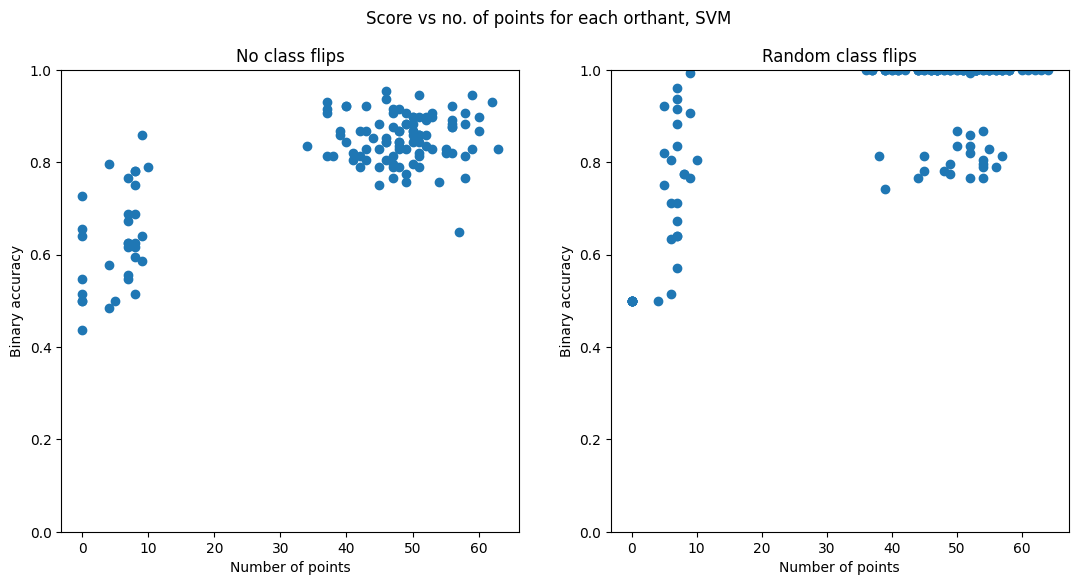

In [59]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('No class flips')

plt.subplot(122)
plt.scatter(orthant_counts_flip, scores_flip_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('Random class flips')

plt.suptitle('Score vs no. of points for each orthant, SVM')

In [60]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_km).statistic, pearsonr(orthant_counts_flip, scores_flip_km).statistic

(0.7920197887423612, 0.7070967082608359)

In [61]:
scores_km.mean(), scores_flip_km.mean()

(0.79736328125, 0.89166259765625)

In [62]:
print('Performance in empty orthants: ', scores_km[ZERO_ORTHANT_INDICES].mean(), scores_flip_km[ZERO_ORTHANT_INDICES_FLIP].mean())
print('Performance in rare orthants: ', scores_km[LOW_ORTHANT_INDICES].mean(), scores_flip_km[LOW_ORTHANT_INDICES_FLIP].mean())
print('Performance in typical orthants: ', scores_km[HIGH_ORTHANT_INDICES].mean(), scores_flip_km[HIGH_ORTHANT_INDICES_FLIP].mean())

Performance in empty orthants:  0.5654296875 0.9306640625
Performance in rare orthants:  0.6533203125 0.8548177083333334
Performance in typical orthants:  0.8527018229166666 0.8976236979166666
